# Customer review timeline (of Sea Temple Port Douglas)

I'm traveling thoughout Australia with a WH visa. I wanted to apply for a extention to my visa. Then, to do so, I have to work either in hospitality or farm for 88 days north of the tropic. I have experience in both farms (picking fruit in New Zealand in a WH as weell) and tourism (in Chile), but this is not New Zealand, here theres is lots of deadly animals everywhere, so a prefer to work inside a Resort rather than in the field. So, I moved to Port Douglas, a very touristic spot.

The work is nice as housekeeper, but I miss my analytics. Of course before I came I wanted to know how is how in this touristic hub y northen Queensland, close to the rainforest of Daintree and one of the best spots to see the gigant coral reef. I knew the major players and I checked their commentaries in TripAdvisor. Later, talking to one of the supervisors about customer reviews I been taught the quality metrics they hold. It seems none of the metrics considered the text -which is my specialization- to build a systematic review though time (I mean, they read thoughtfully the commnets and have some insights how comments vary through time, but not a systematic indicator, let say a number over text or some other pattern more interesting).

I think it is time to apply some analytics to text review the TripAvisor reviews. I updated my scrit to get the data (1880 english reviews) and is time to play.


In [9]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = [9, 6]
import scipy.stats as stats
from __future__ import unicode_literals
plt.style.use(['dark_background'])

In [10]:
data = pd.read_csv('C:/Users/Cami/Google Drive/Python/Pullman/tripullman/test.csv', encoding= "utf-8")
#C:\Users\Cami\Google Drive\Python\Pullman\tripullman


In [11]:
data.shape

(1880, 16)

In [12]:
data.columns

Index([u'N_opinion', u'Nivel', u'Op_sobre', u'autor', u'califica',
       u'calificacion', u'comentario', u'direccion', u'fecha', u'lugar',
       u'nombre', u'region', u'tipo', u'tipo1', u'titulo', u'web'],
      dtype='object')

## How califications distribute

In [13]:
data.califica.describe()

count    1880.000000
mean       42.611702
std         9.860025
min        10.000000
25%        40.000000
50%        50.000000
75%        50.000000
max        50.000000
Name: califica, dtype: float64

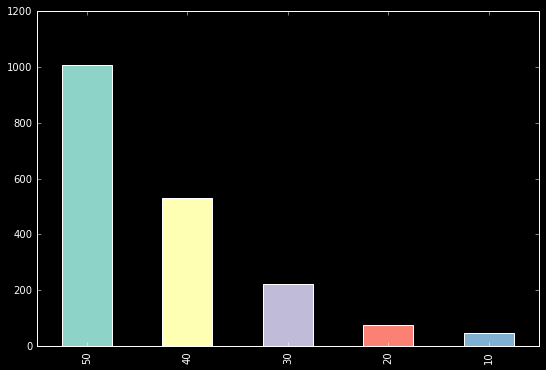

In [14]:
data.califica.value_counts().plot(kind='bar')

## Timeseries
 
First I should see how many commentaries the resort has monthly.

In [15]:
data['fecha2'] = pd.to_datetime(data.fecha,format='%d %B %Y')


In [16]:
dfd = data.copy()
dfd.index = dfd['fecha2']
dfd.index = pd.to_datetime(dfd.index)
dfd = dfd.sort_values('fecha2')

C:\Users\Cami\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


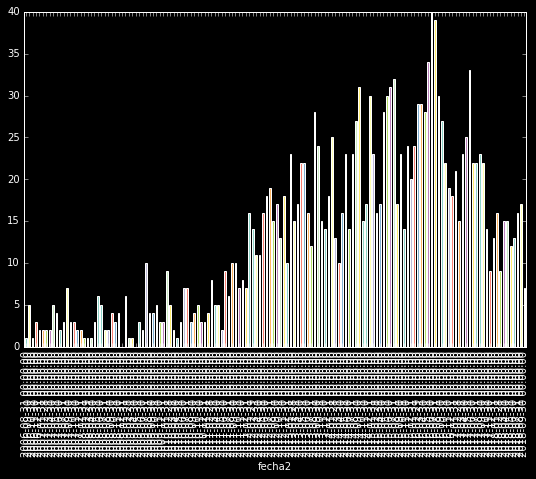

In [17]:
barra=dfd.califica.copy()
barra=barra.resample(rule='M').count()
barra.plot(kind='bar')

OK. So since 2012 comments are 20 each month. reaching a pick in 2017 of up to 40 comments in a single month.

### Calification through time

Let's calculate the calification mean of every month.

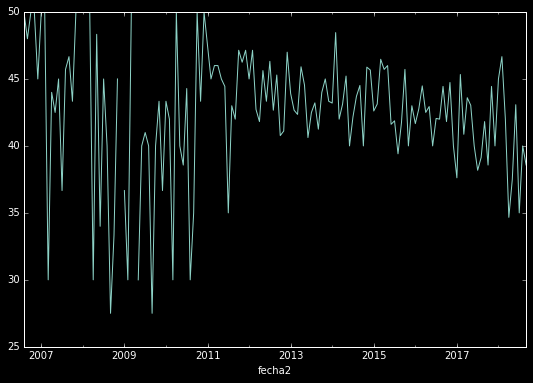

In [18]:
linea=dfd.califica.copy()
linea=linea.resample(rule='M').mean()
linea.plot(kind='line')

It seems that before 2012 -when there is few comments- the mean looks volatile, but then moves aroud 4.5 and its been slighly decreasing. More stable version could be the accumulate version.

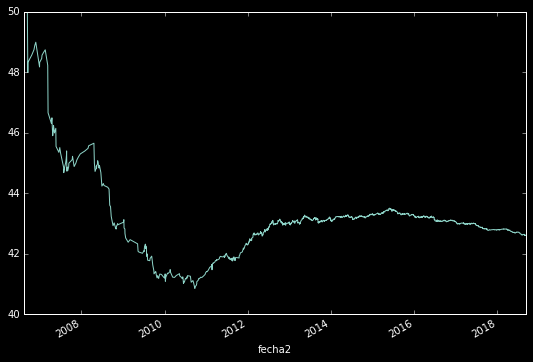

In [19]:
lineaAccum=dfd.califica.copy()
lineaAccum=lineaAccum.expanding().mean()
lineaAccum.plot(kind='line')

Mean becomes more stable as more reviews are added, so to change a reputation over time requires a lot of more comments of different sign. It means that the initial good reputation was easely lower at the begining by few bad comments but then reverse easely as well. But then, when it reachs a plateau, change are more subtle. So the slighly deacrease in the end could hide something.

Lets see the distribution of reviews throught time if we normalize by the amount of reviews. Just take from 2014 and on to take the initial noise out.

C:\Users\Cami\Anaconda2\lib\site-packages\pandas\core\reshape\pivot.py:86: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys, observed=False)


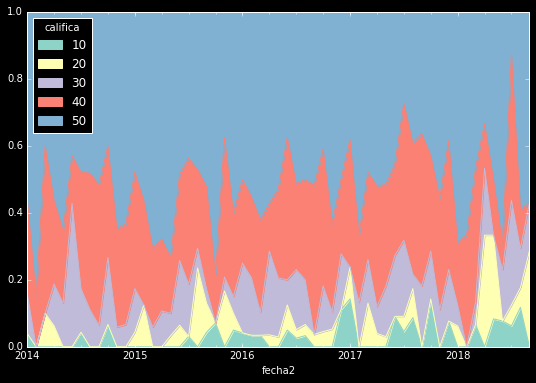

In [20]:
calification=pd.crosstab(dfd.fecha2,dfd.califica)
calification=calification.resample(rule='M').sum()
calification['total']=calification.sum(axis=1)
calification=calification.div(calification.total,0)
calification=calification.drop('total',1)
#calification=pd.concat([calification], keys=calification.index.year, names=['ano'])
calification.loc['2014':,:].plot(kind='area')
#calification.head()

It seems that the last year scores lower than 3 are more common than before. What if we compare year after year.

In [21]:
#calification.loc['2014':'2014',:].plot(kind='area',figsize=(12,4),sharex=True)
#calification.loc['2015':'2015',:].plot(kind='area',figsize=(12,4))
#calification.loc['2016':'2016',:].plot(kind='area',figsize=(12,4))
#calification.loc['2017':'2017',:].plot(kind='area',figsize=(12,4))
#calification.loc['2018':'2018',:].plot(kind='area',figsize=(12,4))
#pd.crosstab(calification.index,[calification.index.year,calification.index])

In [22]:
#calification.unstack(level=0).plot(kind='line', subplots=True, sharex=True)

### Prepare text data and split reviews into sentences

Many reviews are generally positive, but they refer to different things. To make things clearer let's split the reviews into sentences. That way we could note the diference if a comment is about more than one subject.

In [23]:
from nltk.tokenize import word_tokenize, sent_tokenize
dm = data[['titulo','califica','comentario','fecha']].copy()
dm.dropna(inplace=True)
dm['sent']=dm.comentario.apply(sent_tokenize)
dm2= (dm['sent'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('sent').join(dm[['titulo','califica','comentario','fecha']], how='left'))

Check the new data set with a sentence by row

In [24]:
dm3=dm2.reset_index().copy()
dm3.head()

,index,sent,titulo,califica,comentario,fecha
0,0,5 star prices and 3 star service.,First family holiday,30,5 star prices and 3 star service. We stayed in...,14 September 2018
1,0,We stayed in a villa with a private pool which...,First family holiday,30,5 star prices and 3 star service. We stayed in...,14 September 2018
2,0,The maintenance man even said it’s so hard to ...,First family holiday,30,5 star prices and 3 star service. We stayed in...,14 September 2018
3,0,The food is bang average not just at the hotel...,First family holiday,30,5 star prices and 3 star service. We stayed in...,14 September 2018
4,0,The staff are all great and try and make your ...,First family holiday,30,5 star prices and 3 star service. We stayed in...,14 September 2018


## Look for meaning (most significative bi-grams)

#### Extract most common bi-grams and tri-grams

To explore the content fisrt I could have a look of the most frequent words. A simple model of sklearn can give us that information. Lets see some bi-grams and tri-grams.

In [25]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

stp = nltk.corpus.stopwords.words('English') 
dm3.sent.dropna(inplace=True)

vectorizer = TfidfVectorizer(lowercase=True, stop_words=stp[:130] ,ngram_range = (2,3), min_df=5).fit(dm3.sent)
full_matrix = vectorizer.transform(dm3.sent)


C:\Users\Cami\Anaconda2\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [26]:
def display_scores(vectorizer, tfidf_result,n=50):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores[:n]:
        print "{0:50} Score: {1}".format(item[0], item[1])
        
display_scores(vectorizer,full_matrix,25)

sea temple                                         Score: 190.067955653
port douglas                                       Score: 185.099387049
pool bar                                           Score: 69.8731412815
staff friendly                                     Score: 65.5200786592
stayed nights                                      Score: 52.0425385122
room service                                       Score: 51.139810416
pool area                                          Score: 48.8863670619
lagoon pool                                        Score: 44.7722620339
front desk                                         Score: 43.8886533548
golf course                                        Score: 42.389832746
plunge pool                                        Score: 41.6875407997
friendly helpful                                   Score: 38.6354335457
two bedroom                                        Score: 36.1964953103
swimming pool                                      Score: 35.10498

This is the most frequent combinations of words in the reviews. It doesn't seem to be meanful. Let's try another techniques.

### Detect keyphases

We can improve the detection of n-grams. It not only will helt to create keyphases to identify the text but also will improve the understanding of the text itself.

##### Keyphrases with bigrams

In [27]:
import nltk
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from collections import Counter

data_words = [i for i in dm3.sent]
#data_words = dm3.sent.apply(word_tokenize)
data_words = [simple_preprocess(i,deacc=True) for i in data_words]
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


C:\Users\Cami\Anaconda2\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Cami\Anaconda2\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [28]:
print(trigram_mod[bigram_mod[data_words[632]]])

[u'me', u'and', u'my', u'husband', u'visited', u'port_douglas', u'for', u'short', u'stay', u'and', u'booked', u'an', u'accomodation', u'at', u'pullman', u'sea_temple', u'port_douglas']


In [29]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stp] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

text=remove_stopwords(data_words)
text=make_bigrams(text)
text=make_trigrams(text)

In [30]:
dm3.sent = text
dm3.sent = dm3.sent.apply(' '.join)

Since we have some "new words" created on n-grams lets try to check if I can create some keyphases. For that I will use word2Vec or word embeddings, that in theory would help to find synonymous to those phrases.

In [31]:
from gensim.models import Word2Vec

bigram_model = Word2Vec(bigram_mod[data_words], size=100)
bigram_model_counter = Counter()
for key in bigram_model.wv.vocab.keys():
    if key not in stp:
        if len(key.split("_")) > 1:
            bigram_model_counter[key] += bigram_model.wv.vocab[key].count

In [32]:
for key, counts in bigram_model_counter.most_common(30):
    print '{0: <20} {1}'.format(key.encode("utf-8"), counts)

sea_temple           523
port_douglas         512
front_desk           74
golf_course          67
highly_recommend     56
roof_top             56
shuttle_bus          52
well_appointed       47
hot_tub              40
direct_access        35
ground_floor         34
barrier_reef         30
mile_beach           29
school_holidays      29
wedding_anniversary  28
five_star            26
palm_cove            26
hire_car             25
minute_drive         24
four_mile            23
ended_up             22
washer_dryer         21
spiral_staircase     21
ve_ever              20
main_street          20
per_person           19
young_children       19
make_sure            19
self_contained       18
washing_machine      18


Now it looks like we can found some meaning on them.

##### Keyphrases with postagging selection

Another way to try to define some keyphrases is to try to get subject and adjetives of each sentences.

In [33]:
import spacy
nlp = spacy.load('en_core_web_md')

dm3['new_col'] = dm3['sent'].apply(lambda x: nlp(x))

In [34]:
#Function to extract relevant chunks
def get_chunk(sent, chunk="NOUN"):
    chunks=[]
    dep =[]
    tt = []
    for w in sent:
        if w.pos_ == chunk:
            chunks.append(w.text)
        if w.tag_ == "JJ":
            dep.append(w.text)
        if w.dep_ == "neg":
            tt.append(w.text)       
    return chunks + tt + dep
     
dm3['keywords'] = dm3.new_col.apply(get_chunk)
keywords = dm3.keywords.apply(' '.join)

#print dm3.new_col.apply(lambda x: [(i.tag_,i.text) for i in x])

If we collect the most common words we could use them to classify comments later.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
commonWords = cv.fit(keywords)
kw = commonWords.transform(keywords)
display_scores(commonWords,kw,25) 

pool                                               Score: 1531
room                                               Score: 1116
staff                                              Score: 766
great                                              Score: 751
resort                                             Score: 634
hotel                                              Score: 595
spa                                                Score: 558
apartment                                          Score: 541
sea_temple                                         Score: 477
service                                            Score: 475
port_douglas                                       Score: 453
rooms                                              Score: 437
good                                               Score: 423
restaurant                                         Score: 418
area                                               Score: 402
time                                               Score: 400
bedroo



Let's see if we could get something of context for each word



In [36]:
pd.set_option('display.max_colwidth', -1)
dm3.sent[dm3.sent.str.contains('area')].sample(10)

8422    arrived met friendly professional concierge told us upgraded bedroom penthouse comes roof_top terrace spa plus full kitchen lounge dining area
5483    also spiral_staircase outside led upstairs huge terrace area set bbq banana lounges spa                                                       
113     bit wear tear upstairs jacuzzi area however would expected tropics                                                                            
3786    well loved room view spa pool bbq areas excellent                                                                                             
230     dining area allows seating cover pool side                                                                                                    
6081    pool area fantastic                                                                                                                           
7502    area sun_beds allocated guests rooms backing pool sufficient able enjoy pool          

## Semi-Unsupervised Classification of text

Sometimes is hard try to evaluate comments through time. There is a bias toward the last comment we read and we tend to forget the first ones.
So, for a more systematical analysis let's organize the comments to get better understanding of what they said.

For this I could use representations of the text. I could try to get some descriptors as markers and show how they distribute through the time. This will allow me to make visualizations of key concepts in the text.

As there is different areas within a hotel is value to identify marker refered to the work of reception, housekeeping and maintance or food and beverage departments. I found also interesting add another marker for infraestructure and environment.

I cannot read every comment, so I will give a list of words that could be in for each marker. If the algorithm found similarity between que list of words and a sentence it will classify the sentence as is has the most like marker.
As the sentences and the words on them are build as vectors (know as Word embeddings or word2vec) I assuming it will easly found "synonymous".

In [37]:
# We’ll use SpaCy which includes pre-trained vectors for the most common words using the GloVe Common Crawl
doc = dm3['new_col']

In [38]:
topic_labels = [
'Food & Beverage',
  'Housekeeping',
  'Front desk',
    'Environment'
]
# I give a list of words for every topic based on the most common topics
topic_keywords = [
    'food drink burger waiter chef soda wine delicious taste chips beer restaurant',
  'clean room floor sheets toilet bathroom bed spa housekeeper furniture blanket dirt',
    'desk reception luggage call welcome',
  'location atmosphere pool terrace parking beach town lobby hall'    
]

In [39]:
import itertools
import numpy as np

topic_keywords = [i.decode('utf-8') for i in topic_keywords]
# Use pipe to run this in parallel
topic_docs = list(nlp.pipe(topic_keywords,
  batch_size=10000,
  n_threads=3))
topic_vectors = np.array([doc.vector 
  if doc.has_vector else doc.vocab[0].vector
  for doc in topic_docs])


In [40]:
keywords[:3]

0    star prices star service          
1    villa pool looks private tired    
2    maintenance man hotels issues hard
Name: keywords, dtype: object

In [41]:
keyword_docs = list(nlp.pipe(keywords,
  batch_size=10000,
  n_threads=3))


In [42]:
keyword_vectors = np.array([doc.vector 
  if doc.has_vector else nlp.vocab[0].vector
  for doc in keyword_docs])


Now I have the vector for every sentence, I'm able to find the topic for each of them by measuring similarity between sentence vectors and topic vectors and picking the one with the largest likelyhood. I could define a threshold in the case of the similarity within every topic is too low and save it into a "something else" topic.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
# use numpy and scikit-learn vectorized implementations for performance
simple_sim = cosine_similarity(keyword_vectors, topic_vectors)
topic_idx = simple_sim.argmax(axis=1)

topic=[]
probability=[]
for k, i, j in zip(keywords, topic_idx,simple_sim):
    probability.append(j[i])
    if j[i] > 0.55:
        topic.append(topic_labels[i])
    else:
        topic.append("something else")


In [44]:
dm3['topic']=topic
dm3['probability']=probability

Have a look how topics distribute. Its seems Food & Bevarage has the less of mentions, meanwhile enviroment is the largest category.

In [45]:
dm3.topic.value_counts()

Environment        3993
something else     2208
Housekeeping       1433
Front desk         1098
Food & Beverage    804 
Name: topic, dtype: int64

In [46]:
dm3[dm3.topic=='Front desk'].sample(1)

,index,sent,titulo,califica,comentario,fecha,new_col,keywords,topic,probability
8837,1722,room serviced day staff always friendly helpful,"Fantastic resort, great place to relax and unwind.",40,"We've just come back from a one week stay at Sea Temple Port Douglas and it was brilliant. I had read some reviews previous to our departure which were sligtly negative (unclean rooms, non helpful staff), but we could not fault the resort or the staff at all. We travelled with our 4yr and 2yr old, and it was just as much fun for them as it was for us. They spent much of the day playing in and around the pool, and they loved the Spa! We stayed in a 2bed penthouse with the private rooftop spa terrace. It was fantastic. The added space on the roof meant we could run around with the kids while cooking a BBQ lunch, or using our own private spa. The beach was just a 1min walk away, and while 4mile beach is not one of the best beaches around, it still provided lots of fun for the kids, especially at low tide when they could walk well out and explore. We had a car for the week so ate in town every night. We provided our own breakfast, but did have lunch at the pool bar a few times (which was great). If you are travelling with kids you should probably have a car at your disposal as the resort is only a 5min drive out of town, but relying on the shuttle bus could take some fun out of it, and probably take each trip 30mins. The room was serviced each day, and the staff were always very friendly and very helpful. We had an early flight which got us into the resort well ahead of checkin, we did not request an early checkin, but when we arrived they did their best to accomodate us. We waited in town for only an hour when they called to say our room was ready. That was well above the call of duty and we much appreciated it. When our daughter misplaced her goggles, the pool bar staff and reception did their upmost to track them down and got them back to us!! So a big thankyou to all the staff that helped make our stay so enjoyable. We will definitely return.",16 August 2010,"(room, serviced, day, staff, always, friendly, helpful)","[room, day, staff, friendly, helpful]",Front desk,0.745311


Since I have our sentences classified I'm hable to show its distribution through time.

In [47]:
dm3['fecha2'] = pd.to_datetime(dm3.fecha,format='%d %B %Y')
dmd = dm3.copy()
dmd.index = dmd['fecha2']
dmd.index = pd.to_datetime(dmd.index)
dmd = dmd.sort_values('fecha2')

C:\Users\Cami\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """


In [48]:
cat=pd.crosstab(dmd.fecha2, dmd.topic)
cat=cat.resample(rule='M').sum()
cat['total']=cat.sum(axis=1)
cat=cat.div(cat.total,0)
cat=cat.drop('total',1)
cat.head()
#fig = plt.figure()
#plt.plot(cat.index, cat, marker='|', lw=0, ms=10)
#plt.ylim([-0.5, 5.5])

topic,Environment,Food & Beverage,Front desk,Housekeeping,something else
fecha2,,,,,
2006-12-31,0.230769,0.076923,0.153846,0.230769,0.307692
2007-01-31,0.307692,0.076923,0.153846,0.230769,0.230769
2007-02-28,0.250000,0.000000,0.083333,0.333333,0.333333
2007-03-31,0.666667,0.000000,0.000000,0.166667,0.166667
2007-04-30,0.272727,0.000000,0.181818,0.181818,0.363636


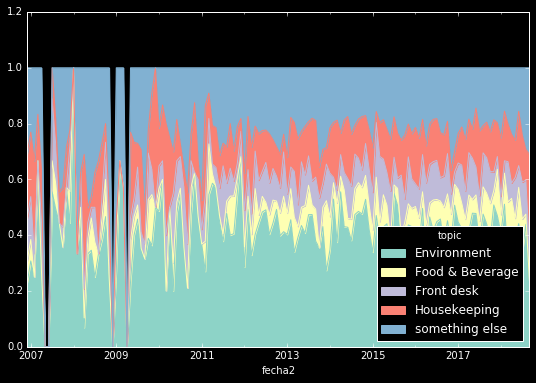

In [49]:
cat.plot(kind='area')

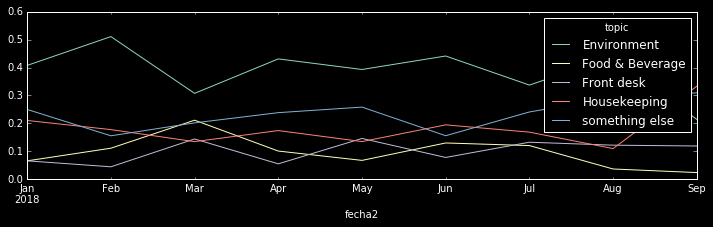

In [50]:
#cat.loc['2014':'2014',:].plot(kind='line',figsize=(12,3))
#cat.loc['2015':'2015',:].plot(kind='line',figsize=(12,3))
#cat.loc['2016':'2016',:].plot(kind='line',figsize=(12,3))
#cat.loc['2017':'2017',:].plot(kind='line',figsize=(12,3))
cat.loc['2018':'2018',:].plot(kind='line',figsize=(12,3))

## Other way to classify reviews: LDA

I used word2vec to automatic classify sentences. But thre si other options available. We could do some topic modeling. The standard algorithm is Latent Dirichlet Allocations or LDA, which will cluster sentences in a given number of topics. We have several ways to procced here. 

### Regular LDA

In [51]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

common_dictionary = Dictionary(text)
common_corpus = [common_dictionary.doc2bow(i) for i in text]
# the model on the corpus.
lda = LdaModel(common_corpus,id2word=common_dictionary, num_topics=20)

In [52]:
lda.print_topics()

[(0,
  u'0.040*"loved" + 0.036*"really" + 0.031*"stay" + 0.030*"sea_temple" + 0.028*"resort" + 0.024*"hotel" + 0.021*"port_douglas" + 0.019*"absolutely" + 0.019*"enjoyed" + 0.017*"people"'),
 (1,
  u'0.045*"port_douglas" + 0.039*"sea_temple" + 0.022*"spa" + 0.017*"stay" + 0.016*"children" + 0.015*"pool" + 0.014*"roof_top" + 0.013*"resort" + 0.012*"suite" + 0.011*"best"'),
 (2,
  u'0.022*"see" + 0.020*"resort" + 0.017*"never" + 0.016*"problem" + 0.016*"love" + 0.015*"like" + 0.014*"still" + 0.012*"bus" + 0.011*"etc" + 0.011*"port_douglas"'),
 (3,
  u'0.070*"pool" + 0.043*"apartment" + 0.033*"beautiful" + 0.029*"bedroom" + 0.029*"room" + 0.025*"two" + 0.025*"swim" + 0.023*"resort" + 0.020*"great" + 0.014*"hotel"'),
 (4,
  u'0.030*"place" + 0.023*"perfect" + 0.020*"us" + 0.016*"room" + 0.016*"resort" + 0.014*"great" + 0.012*"spa" + 0.012*"leave" + 0.011*"could" + 0.011*"relax"'),
 (5,
  u'0.053*"would" + 0.030*"stay" + 0.030*"staff" + 0.022*"definitely" + 0.019*"us" + 0.019*"recommend" + 

### Guided LDA

In [70]:
"""
import guidedlda

X = pd.Series(common_corpus)#guidedlda.datasets.load_data(guidedlda.datasets.NYT)
vocab = common_dictionary#guidedlda.datasets.load_vocab(guidedlda.datasets.NYT)
word2id = dict((v, idx) for idx, v in enumerate(vocab))

#print(X.shape)

#print(X.sum())
# Normal LDA without seeding
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X)

topic_word = model.topic_word_
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))


# Guided LDA with seed topics.
seed_topic_list = [['game', 'team', 'win', 'player', 'season', 'second', 'victory'],
                   ['percent', 'company', 'market', 'price', 'sell', 'business', 'stock', 'share'],
                   ['music', 'write', 'art', 'book', 'world', 'film'],
                   ['political', 'government', 'leader', 'official', 'state', 'country', 'american', 'case', 'law', 'police', 'charge', 'officer', 'kill', 'arrest', 'lawyer']]

model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)

seed_topics = {}
for t_id, st in enumerate(topic_keywords):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
"""

u"\nimport guidedlda\n\nX = pd.Series(common_corpus)#guidedlda.datasets.load_data(guidedlda.datasets.NYT)\nvocab = common_dictionary#guidedlda.datasets.load_vocab(guidedlda.datasets.NYT)\nword2id = dict((v, idx) for idx, v in enumerate(vocab))\n\n#print(X.shape)\n\n#print(X.sum())\n# Normal LDA without seeding\nmodel = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)\nmodel.fit(X)\n\ntopic_word = model.topic_word_\nn_top_words = 8\nfor i, topic_dist in enumerate(topic_word):\n    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]\n    print('Topic {}: {}'.format(i, ' '.join(topic_words)))\n\n\n# Guided LDA with seed topics.\nseed_topic_list = [['game', 'team', 'win', 'player', 'season', 'second', 'victory'],\n                   ['percent', 'company', 'market', 'price', 'sell', 'business', 'stock', 'share'],\n                   ['music', 'write', 'art', 'book', 'world', 'film'],\n                   ['political', 'government', 'leader', 'of

### LDA AND word2Vec

In [69]:
#w=guidedlda.datasets.load_data(guidedlda.datasets.NYT)
#type(w)

# Sentiment analysis

So far I have seen how frequently each section got named, but I don't have idea if it is positive or negative. As most reviews give a high score to the resort we could asumme that most comments are positive, but its not necessary. To do these we could use pre-build polarity sentiment models.

In [54]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [55]:
nltk_results = [nltk_sentiment(row) for row in dm3.sent]

C:\Users\Cami\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [56]:
results_df = pd.DataFrame(nltk_results)
#text_df = pd.DataFrame(dataset, columns = ['text'])
dm4 = dm3.join(results_df)

In [57]:
dm4.columns

Index([      u'index',        u'sent',      u'titulo',    u'califica',
        u'comentario',       u'fecha',     u'new_col',    u'keywords',
             u'topic', u'probability',      u'fecha2',    u'compound',
               u'neg',         u'neu',         u'pos'],
      dtype='object')

In [58]:
dm4['fecha2'] = pd.to_datetime(dm4.fecha,format='%d %B %Y')
dmds = dm4.copy()
dmds.index = dmds['fecha2']
dmds.index = pd.to_datetime(dmds.index)
dmds = dmds.sort_values('fecha2')

C:\Users\Cami\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """


In [59]:
sen=pd.pivot_table(dmds, values='compound', index=['fecha2'],columns=['topic'], aggfunc=np.mean)
sen=sen.resample(rule='M').mean()

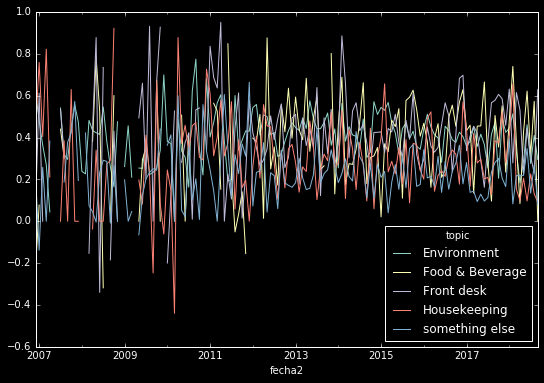

In [60]:
sen.plot(kind='line')

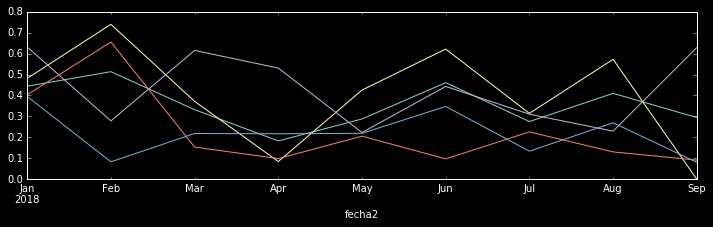

In [61]:
#sen.loc['2014':'2014',:].plot(kind='line', figsize=(12,3))
#sen.loc['2015':'2015',:].plot(kind='line', figsize=(12,3),legend=False)
#sen.loc['2016':'2016',:].plot(kind='line', figsize=(12,3))
#sen.loc['2017':'2017',:].plot(kind='line', figsize=(12,3),legend=False)
sen.loc['2018':'2018',:].plot(kind='line', figsize=(12,3),legend=False)